# Train Soccer Player Detector

---

This notebook is based on the [How to Train YOLOv8 Object Detection on a Custom Dataset](https://github.com/roboflow/notebooks/blob/main/notebooks/train-yolov8-object-detection-on-custom-dataset.ipynb) notebook from the [roboflow/notebooks](https://github.com/roboflow/notebooks) repository.

In [1]:
!nvidia-smi

Mon Oct  7 13:52:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install dependencies

In [3]:
!pip install -q ultralytics roboflow

## Imports

In [4]:
from roboflow import Roboflow
from google.colab import userdata
from IPython.display import Image

## Pull dataset

In [22]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(12)
dataset = version.download("yolov8")


mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.3.6, to fix: `pip install ultralytics==8.0.196`


**NOTE:** Update `data.yaml` structure to align with the latest requirements of the `ultralytics` package.



In [23]:
!sed -i 's|\(train: \).*|\1../train/images|' {dataset.location}/data.yaml
!sed -i 's|\(val: \).*|\1../valid/images|' {dataset.location}/data.yaml

## Custom training

In [7]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8x.pt data={dataset.location}/data.yaml batch=3 epochs=50 imgsz=1280 plots=True

/content
Ultralytics 8.3.6 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/datasets/football-players-detection-12/data.yaml, epochs=50, time=None, patience=100, batch=3, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show

In [18]:
!ls {HOME}/runs/detect/train2/

args.yaml					    R_curve.png		 train_batch4002.jpg
confusion_matrix_normalized.png			    results.csv		 val_batch0_labels.jpg
confusion_matrix.png				    results.png		 val_batch0_pred.jpg
events.out.tfevents.1728309193.028d88f1ea38.1585.0  roboflow_deploy.zip  val_batch1_labels.jpg
F1_curve.png					    state_dict.pt	 val_batch1_pred.jpg
labels_correlogram.jpg				    train_batch0.jpg	 val_batch2_labels.jpg
labels.jpg					    train_batch1.jpg	 val_batch2_pred.jpg
model_artifacts.json				    train_batch2.jpg	 weights
P_curve.png					    train_batch4000.jpg
PR_curve.png					    train_batch4001.jpg


/content


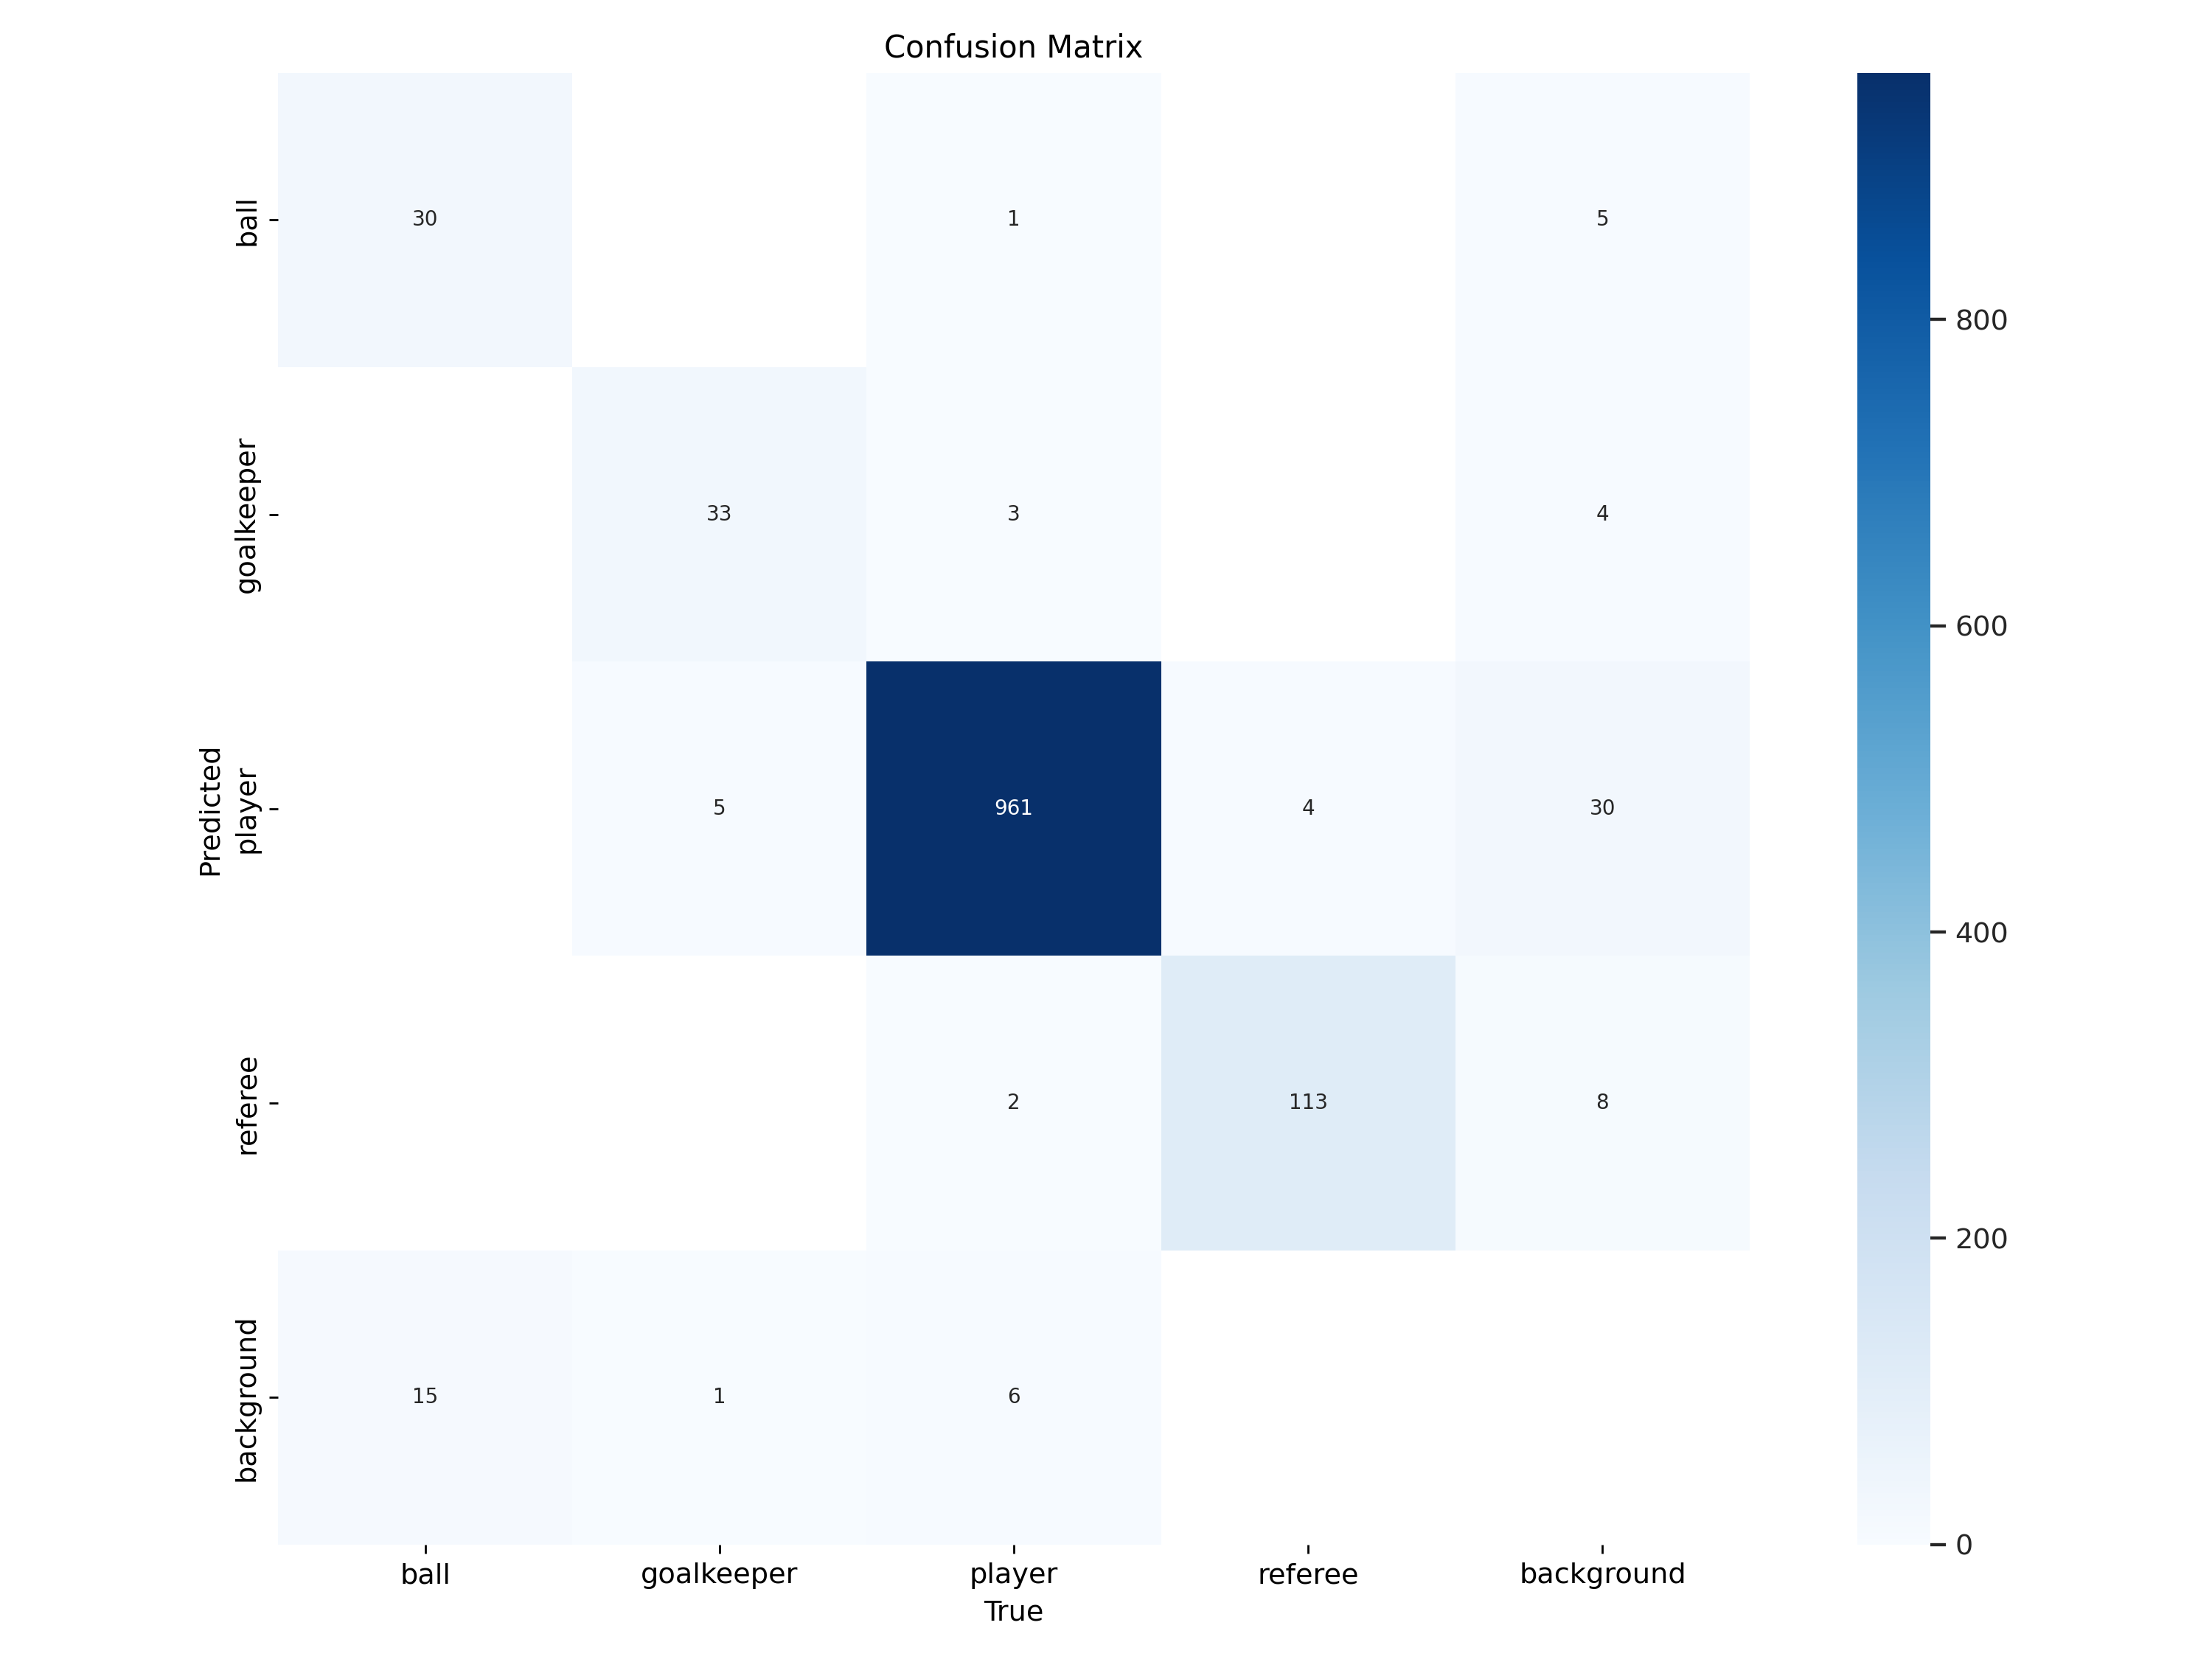

In [10]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=600)

/content


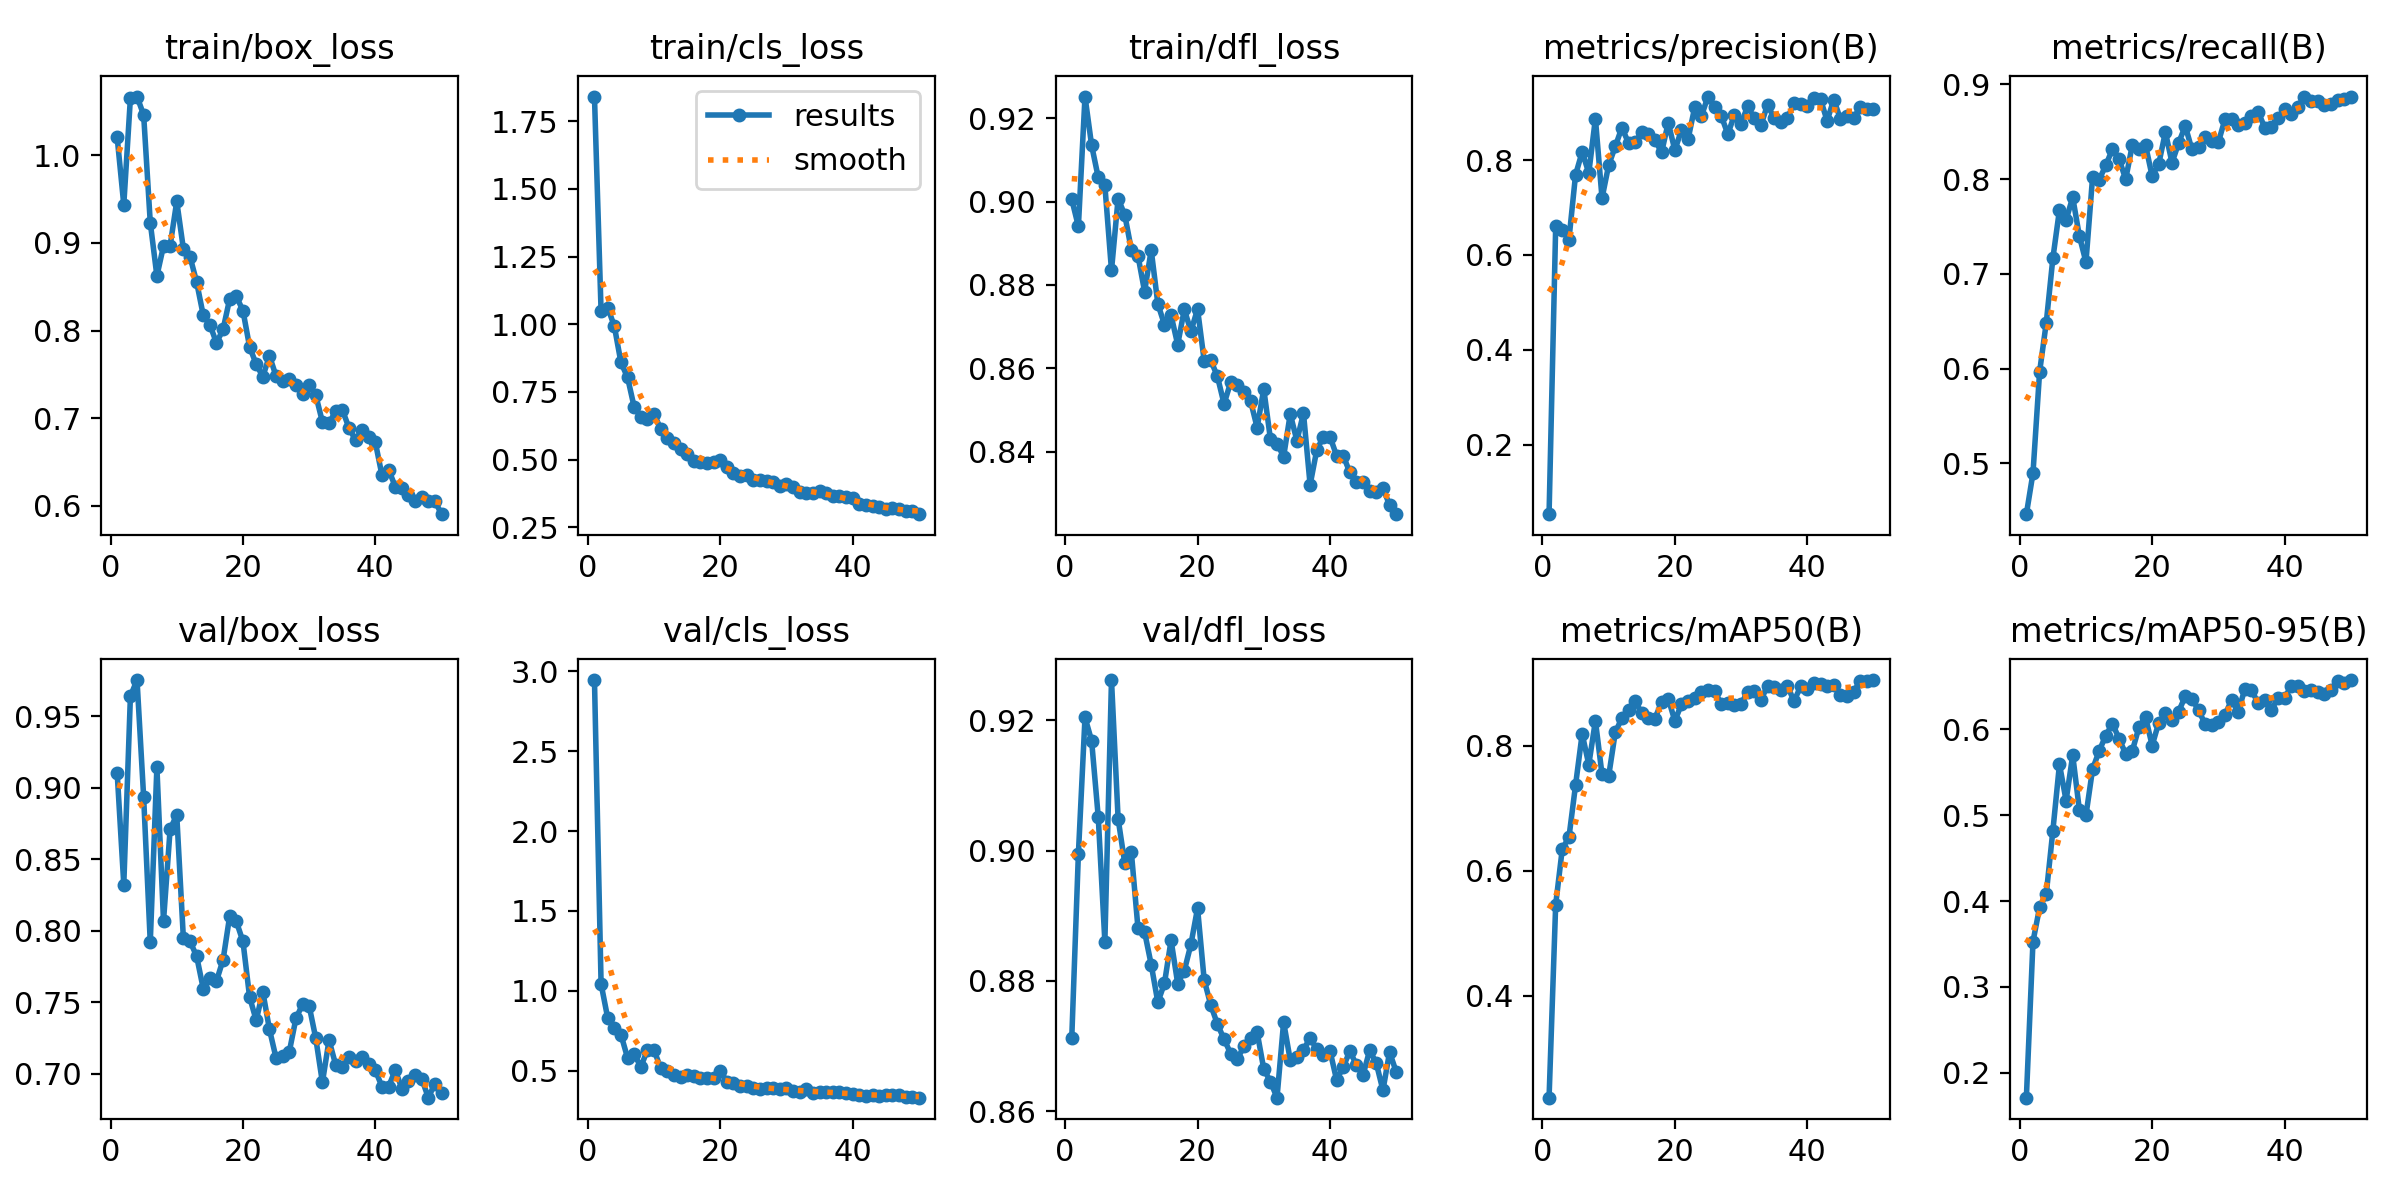

In [12]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/results.png', width=600)

/content


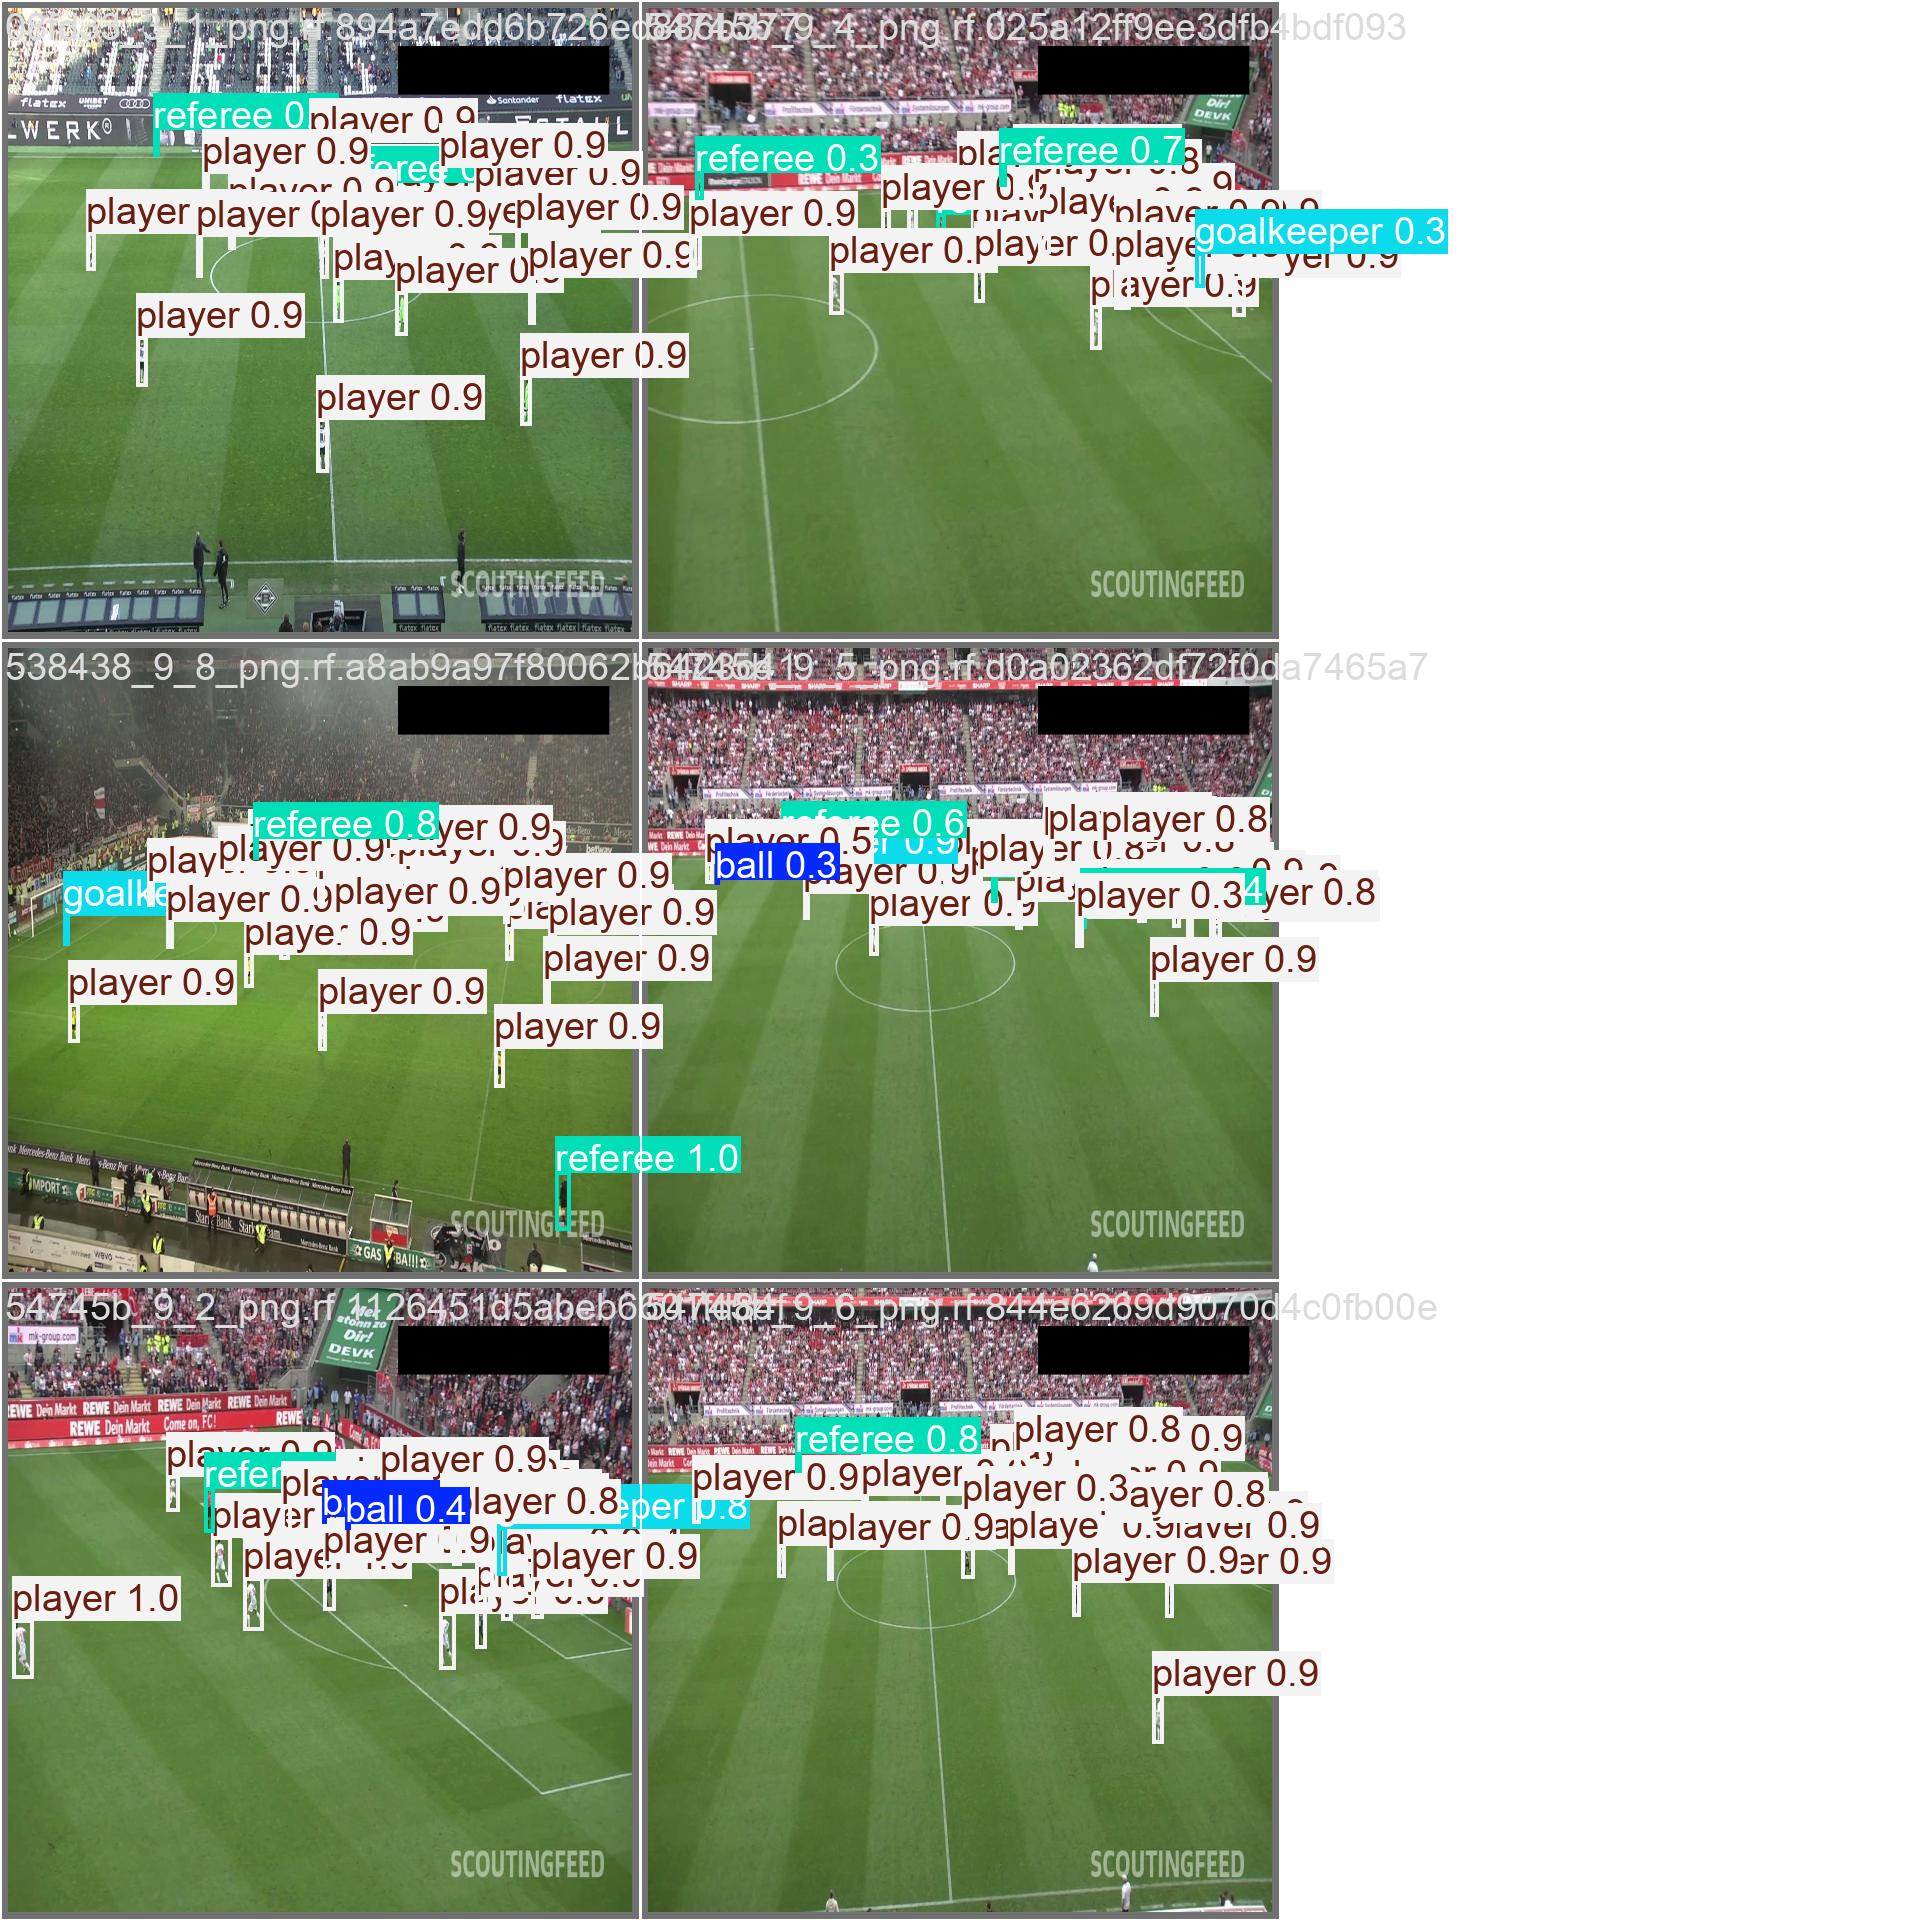

In [13]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', width=600)

## Validate custom model

In [15]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train2/weights/best.pt data={dataset.location}/data.yaml imgsz=1280

/content
Ultralytics 8.3.6 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 286 layers, 61,599,420 parameters, 0 gradients, 226.7 GFLOPs
val: Scanning /content/datasets/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100% 49/49 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:13<00:00,  3.29s/it]
                   all         49       1174      0.906      0.885      0.894      0.662
                  ball         45         45      0.827      0.637      0.638      0.311
            goalkeeper         38         39      0.888      0.923      0.961      0.753
                player         49        973      0.968       0.99      0.994       0.85
               referee         49        117      0.943       0.99      0.982      0.733
Speed: 26.4ms preprocess, 196.3ms inference, 0.1ms loss, 23.4ms postprocess per image
Results saved to runs/

## Deploy model on Roboflow

In [21]:
project.version(dataset.version).deploy(model_type="yolov8", model_path=f"{HOME}/runs/detect/train2/")

Dependency ultralytics==8.0.196 is required but found version=8.3.6, to fix: `pip install ultralytics==8.0.196`
Would you like to continue with the wrong version of ultralytics? y/n: y
An error occured when getting the model upload URL: 404 Client Error: Not Found for url: https://api.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/12/uploadModel?api_key=HXzucUTanOclygZNvFHi&modelType=yolov8&nocache=true
